In [ ]:
!pip install nltk
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install -U imbalanced-learn
!pip install pyspellchecker

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Oculta warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
# Tamaño del subconjunto de documentos con el que se va a trabajar.
# Se tomarán num_docs para training/validadación y num_docs para test.
num_docs = 20000
num_docs_test = 10000


# CARGAR DATOS

**DATOS DE ENTRENAMIENTO**

la columna de trastornos indica si el TWEET es de una persona con depresión o es de control.


**control**:     0

**depresión**:   1



In [ ]:
ruta_archivo_entrenamiento = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs depresión)/train.csv'
data_train = pd.read_csv(ruta_archivo_entrenamiento, sep=',')
#data_train = data.iloc[:num_docs, :]
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263950 entries, 0 to 263949
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     263950 non-null  object 
 1   TWEET_ID    263920 non-null  float64
 2   TWEET_TEXT  263841 non-null  object 
 3   trastorno   263950 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 8.1+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,RT @Julii_AKD: por qué a la mayoría de las pib...,1
1,6,2.147484e+09,Empezar un 2017 sintiéndote solo.,1
2,279,2.147484e+09,Ah mirá que lindo como me escrachan en Instagr...,0
3,518,2.147484e+09,https://t.co/hC3rULMb1P,0
4,301,2.147484e+09,"Tu sigue con él, cumple tu deber, muy pronto v...",0
5,177,2.147484e+09,@Sebbasrp deje dormir al prójimo.,0
6,45,2.147484e+09,"RT @Crookedgirlx: no quiero vivir más, estoy c...",1
7,29,2.147484e+09,RT @Esunbreakable: Me da un poquito de vergüen...,1
8,388,2.147484e+09,Venezuela-related Designation https://t.co/IOZ...,0
9,31,2.147484e+09,Tengo muchas ganas de escribirte para decirte ...,1


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'trastorno'
null_values = data_train['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno':", null_values)

Número de filas nulas o vacías en la columna 'trastorno': 0


**DATOS DE PRUEBA**

In [ ]:
ruta_archivo_prueba = '/content/drive/MyDrive/Experimentación Python Tesis /entrenamiento y prueba (control vs depresión)/test.csv'
data_test = pd.read_csv(ruta_archivo_prueba, lineterminator='\n')
#data_test =data_t.iloc[:num_docs_test, :]
data_test.info()
data_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113075 entries, 0 to 113074
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   USER_ID     113075 non-null  int64 
 1   TWEET_ID    113075 non-null  int64 
 2   TWEET_TEXT  113075 non-null  object
 3   trastorno   113075 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.5+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,30,2147483647,RT @Unicornio_Azul5: ¿Está mal desear estar mu...,1
1,508,2147483647,RT @tachame_ladoble: Esta noche!! Volvemos a V...,0
2,279,2147483647,RT @PsychdelicPics: Art by I Love Doodle https...,0
3,12,2147483647,Hoy no he pasado de las 700kcal.,1
4,277,2147483647,RT @NetSportAcademy: Elisa Luque se proclama c...,0


In [ ]:
# Verificar si hay filas nulas o vacías en la columna 'trastorno'
null = data_test['trastorno'].isnull().sum()

# Imprimir el número de filas nulas o vacías
print("Número de filas nulas o vacías en la columna 'trastorno':", null)

Número de filas nulas o vacías en la columna 'trastorno': 0


# Preparación de los datos

*Eliminar etiquedas HTML*

In [ ]:
import re

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string

In [ ]:
import nltk
nltk.download('stopwords')  #Solamente se ha de descargar la primera vez.
stopwords_en = nltk.corpus.stopwords.words('spanish')   # Extrae las stopwords en español

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


*Limpiar texto*

In [ ]:
import re
import string

def clean(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        # Eliminar hashtags
        text = re.sub(r'#\w+', '', text)

        # Eliminar URLs o enlaces
        text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

        # Eliminar nombres de usuarios de Twitter
        text = re.sub(r'@\w+', '', text)

        # Eliminar Nombres propios
        text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

        # Eliminar todos los caracteres especiales
        text = re.sub(r'[^\w\s]+', '', text)

        # Eliminar prefijos y números
        text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

        # Eliminar palabras específicas
        specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                          'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                          'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                          'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                          'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                          'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                          'it','we','they','the','and','that','these','those','tweet','followed','follower']
        text = ' '.join([word for word in text.split() if word not in specific_words])

        # Eliminar emojis
        emojis = re.findall(r'[^\w\s,]', text)
        cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                     '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                     ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
        for emoji in cleaned_emojis:
            text = text.replace(emoji, '')

        # Convertir el texto a minúsculas
        text = text.lower()

        # Eliminar signos de puntuación
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

        words = text.split() #divide el texto en palabras individuales, creando una lista de palabras.

      # Combinar las stopwords en  español
        all_stopwords = stopwords_en
      # Filtrar las stopwords del texto
        filtered_words = [word for word in words if word.lower() not in all_stopwords] #filtra las palabras vacías del texto que no están en la lista de palabras vacías

        # Unir las palabras filtradas en un solo texto
        filtered_text = ' '.join(filtered_words)

        # Devuelve el texto limpio
        return text
    else:
        return text  # Devolver el valor original si no es de tipo string



#Elaboración de la lista de palabras relevantes a partir de una bolsa de palabras del mismo conjunto de datos

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))

# Inicializar stemmer de NLTK
stemmer = PorterStemmer()

In [ ]:
# # Función para lematizar y extraer términos
# from nltk.stem import SnowballStemmer

# spanish_stemmer = SnowballStemmer('spanish')

# def extractTerms(text):
#     # Tokenización y lematización con spaCy
#     doc = nlp(text)
#     lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

#     # Stemming con SnowballStemmer de NLTK
#     stemmed_terms = [spanish_stemmer.stem(term) for term in lemmatized_terms]

#     return stemmed_terms
# # Ejemplo de uso
# texto_ejemplo = "Los perrito  están corriendo en el parque y jugando felices."
# terminos_extraidos = extractTerms(texto_ejemplo)
# print(terminos_extraidos)

In [ ]:
import pandas as pd
import spacy
from spacy.lang.es import Spanish
from nltk.corpus import stopwords


# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")

# Cargar stopwords en español
stopwords_es = set(stopwords.words('spanish'))
def extractTerms(text):
    if isinstance(text, str):
        # Tokenización y lematización con spaCy
        doc = nlp(text)
        lemmatized_terms = [token.lemma_ for token in doc if token.text.lower() not in stopwords_es]

        return lemmatized_terms
    else:
        return []  # Devolver una lista vacía si el texto no es una cadena de texto

# Ejemplo de uso
texto_ejemplo = "Los gatos están saltando sobre las vallas"
terminos_extraidos = extractTerms(texto_ejemplo)
print(terminos_extraidos)

['gato', 'saltar', 'valla']


# Preprocesamieto del conjunto de datos de entrenamiento

In [ ]:
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(removeHTML)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(clean)
data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(extractTerms)
data_train.head(10)

,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,"[mayoría, piba, gustar, tener, pierna, grande,...",1
1,6,2.147484e+09,"[sintiéndote, solo]",1
2,279,2.147484e+09,"[mier, lindo, escrachan, magnifico]",0
3,518,2.147484e+09,[],0
4,301,2.147484e+09,"[seguir, cumple, deber, pronto, vestido, novia...",0
5,177,2.147484e+09,"[dejar, dormir, prójimo]",0
6,45,2.147484e+09,"[querer, vivir, cansado]",1
7,29,2.147484e+09,"[poquito, vergüenza, alguien, querer, alzarme,...",1
8,388,2.147484e+09,[related],0
9,31,2.147484e+09,"[mucho, gana, escribirtar, decirte, extraño, d...",1


In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)


Número de elementos vacíos en la columna 'TWEET_TEXT': 17995


In [ ]:
# Filtrar filas donde 'TWEET_TEXT' no sea una lista vacía
data_train = data_train[data_train['TWEET_TEXT'].apply(len) > 0]

# Reiniciar el índice del DataFrame después de eliminar filas
data_train.reset_index(drop=True, inplace=True)

In [ ]:
# Verificar si hay elementos vacíos en la columna 'TWEET_TEXT'
empty_count = (data_train['TWEET_TEXT'].apply(len) == 0).sum()

# Imprimir el número de elementos vacíos en la columna 'TWEET_TEXT'
print("Número de elementos vacíos en la columna 'TWEET_TEXT':", empty_count)

Número de elementos vacíos en la columna 'TWEET_TEXT': 0


In [ ]:
# from spellchecker import SpellChecker

# def corrector_ortografico(tokens):
#     spell = SpellChecker(language='es')
#     tokens_corregidos = [spell.correction(token) if spell.correction(token) is not None else token for token in tokens]
#     return tokens_corregidos

# def corregir_palabras_largas(tokens):
#     tokens_corregidos = []
#     for token in tokens:
#         # Corregir repeticiones de letras
#         token_corregido = re.sub(r'(.)\1+', r'\1\1', token)

#         # Corregir alargamiento de palabras
#         token_corregido = re.sub(r'(\w)\1{2,}', r'\1\1', token_corregido)

#         # Eliminar vocales repetidas más de 2 veces seguidas
#         token_corregido = re.sub(r'([aeiouáéíóú]{2,})\1+', r'\1', token_corregido, flags=re.IGNORECASE)

#         tokens_corregidos.append(token_corregido)
#     return tokens_corregidos

In [ ]:
# data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(corregir_palabras_largas)
# data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(corrector_ortografico)

data_train['TWEET_TEXT'] = data_train['TWEET_TEXT'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x) # Combinar los elementos de la lista en una sola cadena separados por espacios
data_train.info()
data_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245955 entries, 0 to 245954
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   USER_ID     245955 non-null  object 
 1   TWEET_ID    245955 non-null  float64
 2   TWEET_TEXT  245955 non-null  object 
 3   trastorno   245955 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 7.5+ MB


,USER_ID,TWEET_ID,TWEET_TEXT,trastorno
0,87,2.147484e+09,mayoría piba gustar tener pierna grande linda ...,1
1,6,2.147484e+09,sintiéndote solo,1
2,279,2.147484e+09,mier lindo escrachan magnifico,0
3,301,2.147484e+09,seguir cumple deber pronto vestido novia estar...,0
4,177,2.147484e+09,dejar dormir prójimo,0
5,45,2.147484e+09,querer vivir cansado,1
6,29,2.147484e+09,poquito vergüenza alguien querer alzarme pesar...,1
7,388,2.147484e+09,related,0
8,31,2.147484e+09,mucho gana escribirtar decirte extraño deber h...,1
9,2,2.147484e+09,desear mudar yo,1


# Representación de los datos mediante una matriz TF-IDF

se guardan los valores de la matriz TFIDF y los array X y para futuros entrenamientos

Se procederá a construir un conjunto de entrenamiento a partir de la representación de bolsa de palabras o inglés (Bag of Words.)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def Tokenizer(text):
    return text.split()  # Tokenizador simple: divide el texto en palabras
# Crear un transformador CountVectorizer con el tokenizer Tokenizery rango de n-gramas (1, 1)
# y un umbral de frecuencia mínimo de 20
umbral = 20

# Crear un transformador TfidfVectorizer con el tokenizer extractTerms y rango de n-gramas (1, 1)
tfidf_vect  = TfidfVectorizer(tokenizer=Tokenizer, ngram_range=(1, 1), min_df=umbral)
# Aplicar el TfidfVectorizer a la columna 'TWEET_TEXT' en data_train y obtener la matriz TF-IDF
tfidf_train  = tfidf_vect.fit_transform(data_train['TWEET_TEXT'].values)
# Imprimir el tamaño del vocabulario construido por TfidfVectorizer
print("El tamaño del vocabulario es: ", len(tfidf_vect.vocabulary_))

X = tfidf_train # Matriz TF-IDF
y = data_train['trastorno'].values # Etiquetas de trastorno de la columna 'trastorno'


El tamaño del vocabulario es:  5952


In [ ]:
print(X.shape)
print(y.shape)

(245955, 5952)
(245955,)


#Dividir la matriz BoW en 20 secciones de 12,297 mil
la matriz de divide en valores de X1 hasa X20 don sus estiquedas de y1 hasta y20, esto permite entrenar a la red neuronal con pequeños valores sin cambiar el numero de vacabulario total.

In [ ]:
# Se guardan los primeros 12297 datos de la matriz BoW con los respectivas etiquetas y en X1, y1 hasta X20,y20 así hasta
# completar los 245524 datos del dataset

# matrices bow_train
total_datos = tfidf_train.shape[0]  # Número total de filas en la matriz bow_train.
tamaño_conjunto = 12297 #  Tamaño deseado para cada conjunto

# etiquetas están en la variable 'y'
etiquetas = data_train['trastorno'].values

# Crea variables para guardar los conjuntos
conjuntos_X = []
conjuntos_y = []

# Divide tus datos en 20 conjuntos de 12297 filas cada uno
for i in range(20):
    inicio = i * tamaño_conjunto #calcula el índice de inicio del conjunto actual.
    fin = (i + 1) * tamaño_conjunto # índice de finalización del conjunto actual i + 1 representa la siguiente iteración del bucle, por lo que se multiplica por tamaño_conjunto para obtener la fila de finalización.
    #Generan nombres de variables dinámicos para los conjuntos de datos y etiquetas de cada conjunto.
    X_nombre = f'X{i+1}'
    y_nombre = f'y{i+1}'
    conjunto_X = tfidf_train[inicio:fin, :]  # selecciona las filas correspondientes a este conjunto desde la matriz bow_train. Utiliza la notación de corte (slicing) para seleccionar las filas desde inicio hasta fin.
    conjunto_y = etiquetas[inicio:fin]  # selecciona las etiquetas correspondientes a este conjunto. Estas etiquetas se toman de la variable etiquetas que contiene las etiquetas de sentimientos.
    #  Asignan los conjuntos de datos y etiquetas a variables con nombres dinámicos (X1, y1, X2, y2, etc.)
    globals()[X_nombre] = conjunto_X
    globals()[y_nombre] = conjunto_y
    # Agregan los conjuntos de datos y etiquetas a las listas, respectivamente, para mantener un registro de todos los conjuntos creados.
    conjuntos_X.append(conjunto_X)
    conjuntos_y.append(conjunto_y)

**genreal valores aleatorios de X, y para el entrenamiento de la red neuronal**

In [ ]:
import random

# Genera un número aleatorio entre 1 y 8
i = random.randint(1, 20)
# Crea las variables Xi y yi con los datos seleccionados aleatoriamente
Xi = globals()[f'X{i}']
yi = globals()[f'y{i}']
print(f'X{i}', Xi.shape)
print(f'y{i}', yi.shape)

X19 (12297, 5952)
y19 (12297,)


# Entrenamiento con validación 70 - 30

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Convertir la matriz BoW a una matriz densa de Numpy
X = Xi.toarray()
y=yi
# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
# Verificar las dimensiones de los conjuntos de entrenamiento y validación
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_val:", y_val.shape)

Dimensiones de X_train: (9222, 5952)
Dimensiones de X_val: (3075, 5952)
Dimensiones de y_train: (9222,)
Dimensiones de y_val: (3075,)


# Aprendizaje del modelo: Red Neuronal simple

In [ ]:

# Crear una red neuronal secuencial
model_R = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model_R.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model_R.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model_R.add(Dense(64, activation='relu'))
model_R.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model_R.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model_R.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo en los datos de entrenamiento
history = model_R.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de validación
y_val_pred = (model_R.predict(X_val) > 0.5).astype(int)

# Calcular métricas de evaluación en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred = (model_R.predict(X_train) > 0.5).astype(int)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)
# Guardar el modelo entrenado
model_R.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Técnicas de N-gram y TF-IDF/Experimentación pt2 red neuronal/modelo_entrenado_BoW.h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Técnicas de N-gram y TF-IDF/Experimentación pt2 red neuronal/modelo_entrenado_BoW.h5')



Epoch 1/10
289/289 [==============================] - 3s 5ms/step - loss: 0.5966 - accuracy: 0.6765 - val_loss: 0.5486 - val_accuracy: 0.7171
Epoch 2/10
289/289 [==============================] - 1s 4ms/step - loss: 0.4238 - accuracy: 0.8036 - val_loss: 0.5684 - val_accuracy: 0.7164
Epoch 3/10
289/289 [==============================] - 1s 4ms/step - loss: 0.3193 - accuracy: 0.8597 - val_loss: 0.6566 - val_accuracy: 0.7099
Epoch 4/10
289/289 [==============================] - 1s 4ms/step - loss: 0.2242 - accuracy: 0.9073 - val_loss: 0.7889 - val_accuracy: 0.6972
Epoch 5/10
289/289 [==============================] - 1s 4ms/step - loss: 0.1521 - accuracy: 0.9379 - val_loss: 0.9152 - val_accuracy: 0.6901
Epoch 6/10
289/289 [==============================] - 1s 4ms/step - loss: 0.1065 - accuracy: 0.9596 - val_loss: 1.1155 - val_accuracy: 0.6963
Epoch 7/10
289/289 [==============================] - 1s 4ms/step - loss: 0.0862 - accuracy: 0.9670 - val_loss: 1.2275 - val_accuracy: 0.6969
Epoch 

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 98.0%
Precisión (entrenamiento): 99.0%
Recall (entrenamiento): 97.0%
F1-score (entrenamiento): 98.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 69.0%
Precisión en el conjunto de validación: 71.0%
Recall en el conjunto de validación: 63.0%
F1-score en el conjunto de validación: 67.0%


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model_R.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

97/97 [==============================] - 0s 1ms/step
Matriz de confusión: 

 [[1174  393]
 [ 559  949]] 

Proporción de comentarios positivos: 0.49
Proporción de comentarios positivos etiquetados: 0.44


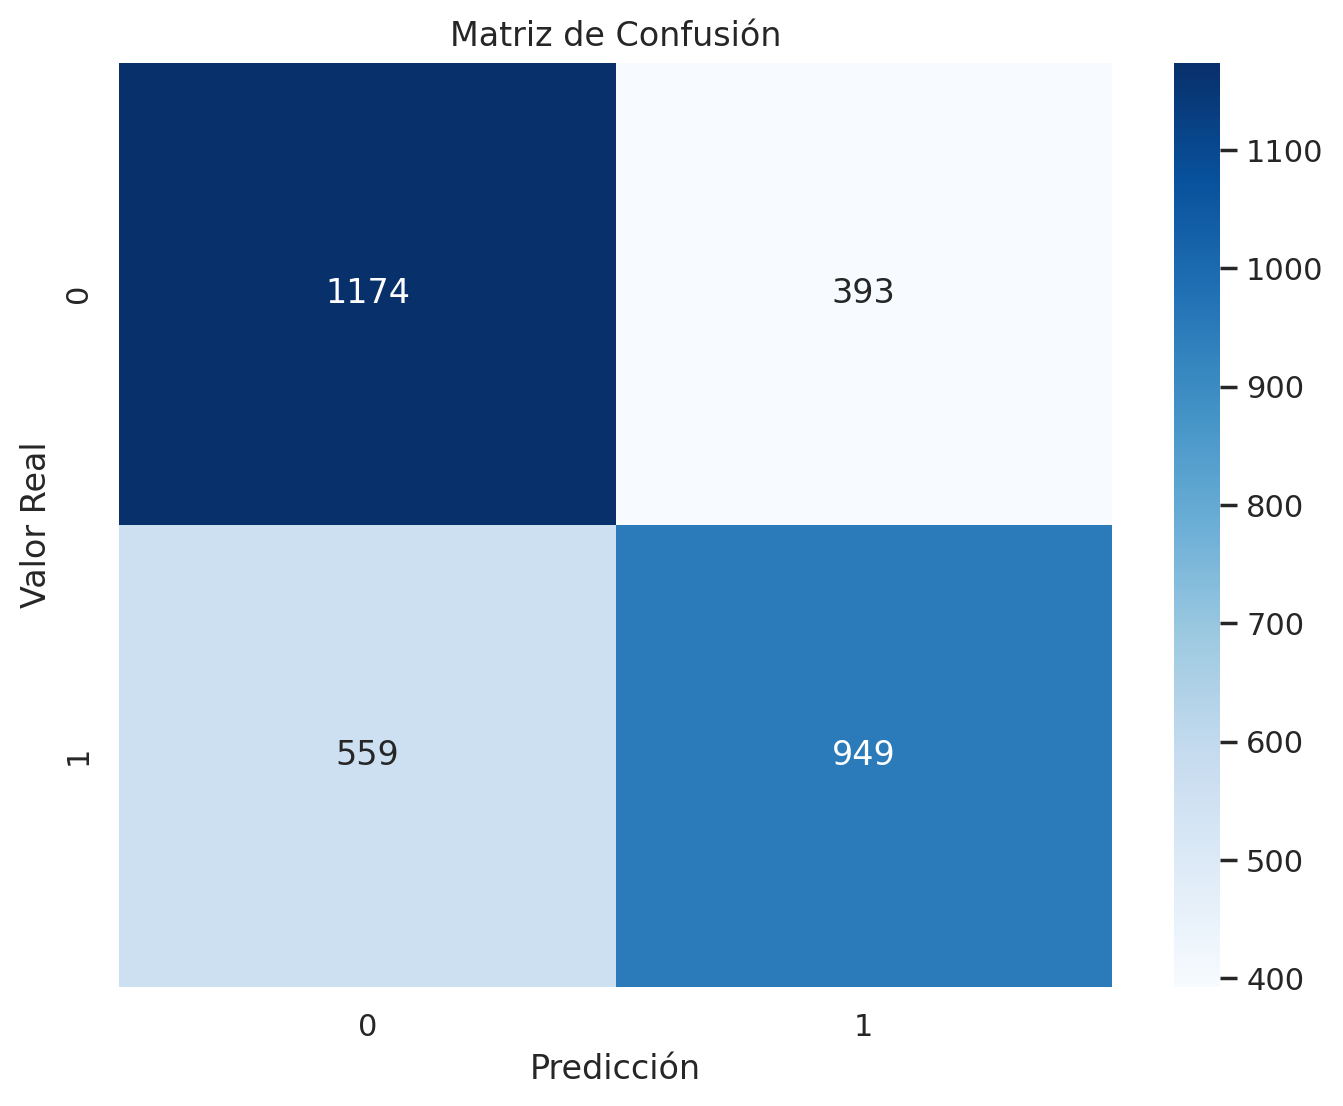

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

In [ ]:
y = np.array(y)

# Entrenamiento con validación cruzada k=10

In [ ]:
# Crear una red neuronal secuencial
model = Sequential()

# Agregar una capa de entrada con el número de características (vocabulario) en tu matriz TF-IDF
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Definir la estrategia de validación cruzada (k=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Listas para almacenar métricas de entrenamiento y validación
train_accuracy_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

# Realizar la validación cruzada
for train_index, val_index in cv.split(X_train, y_train):
    X_train_index, X_val_index = X_train[train_index], X_train[val_index]
    y_train_index, y_val_index = y[train_index], y[val_index]

    # Entrenar el modelo en los datos de entrenamiento
    model.fit(X_train_index, y_train_index, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = (model.predict(X_train_index) > 0.5).astype(int)

    # Calcular métricas de entrenamiento y agregarlas a las listas
    train_accuracy_scores.append(accuracy_score(y_train_index, y_train_pred))
    train_precision_scores.append(precision_score(y_train_index, y_train_pred))
    train_recall_scores.append(recall_score(y_train_index, y_train_pred))
    train_f1_scores.append(f1_score(y_train_index, y_train_pred))

# Calcular las métricas promediadas en entrenamiento
train_accuracy_mean = np.mean(train_accuracy_scores)
train_precision_mean = np.mean(train_precision_scores)
train_recall_mean = np.mean(train_recall_scores)
train_f1_mean = np.mean(train_f1_scores)

# Imprimir las métricas en entrenamiento
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))

# Listas para almacenar métricas de validación
val_accuracy_scores = []
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []

# Realizar la validación cruzada
for train_index, val_index in cv.split(X_train, y_train):
    X_train_index, X_val_index = X_train[train_index], X_train[val_index]
    y_train_index, y_val_index = y_train[train_index], y_train[val_index]

    # Entrenar el modelo en los datos de entrenamiento
    model.fit(X_train_index, y_train_index, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = (model.predict(X_val_index) > 0.5).astype(int)

    # Calcular métricas de validación y agregarlas a las listas
    val_accuracy_scores.append(accuracy_score(y_val_index, y_val_pred))
    val_precision_scores.append(precision_score(y_val_index, y_val_pred))
    val_recall_scores.append(recall_score(y_val_index, y_val_pred))
    val_f1_scores.append(f1_score(y_val_index, y_val_pred))

# Calcular las métricas promediadas en validación
val_accuracy_mean = np.mean(val_accuracy_scores)
val_precision_mean = np.mean(val_precision_scores)
val_recall_mean = np.mean(val_recall_scores)
val_f1_mean = np.mean(val_f1_scores)

# Imprimir las métricas en validación
print("Validación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Técnicas de N-gram y TF-IDF/Experimentación pt2 red neuronal/modelo_entrenado_TFIDF(k=10).h5')

# Cargar el modelo entrenado
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Experimentación Python Tesis /Experimento Dataset Depresión/Técnicas de N-gram y TF-IDF/Experimentación pt2 red neuronal/modelo_entrenado_TFIDF(k=10).h5')



260/260 [==============================] - 0s 2ms/step
Entrenamiento - Accuracy: 96.23%
Entrenamiento - Precision: 96.84%
Entrenamiento - Recall: 95.55%
Entrenamiento - F1 Score: 96.16%
29/29 [==============================] - 0s 2ms/step
Validación - Accuracy: 94.58%
Validación - Precision: 95.14%
Validación - Recall: 93.93%
Validación - F1 Score: 94.53%


In [ ]:
# Imprimir las métricas en entrenamiento
print("Entrenamiento - Accuracy: {:.2f}%".format(100 * train_accuracy_mean))
print("Entrenamiento - Precision: {:.2f}%".format(100 * train_precision_mean))
print("Entrenamiento - Recall: {:.2f}%".format(100 * train_recall_mean))
print("Entrenamiento - F1 Score: {:.2f}%".format(100 * train_f1_mean))
print('-----------------------------------------------------------------------')
# Imprimir las métricas en validación
print("Validación - Accuracy: {:.2f}%".format(100 * val_accuracy_mean))
print("Validación - Precision: {:.2f}%".format(100 * val_precision_mean))
print("Validación - Recall: {:.2f}%".format(100 * val_recall_mean))
print("Validación - F1 Score: {:.2f}%".format(100 * val_f1_mean))

Entrenamiento - Accuracy: 96.23%
Entrenamiento - Precision: 96.84%
Entrenamiento - Recall: 95.55%
Entrenamiento - F1 Score: 96.16%
-----------------------------------------------------------------------
Validación - Accuracy: 94.58%
Validación - Precision: 95.14%
Validación - Recall: 93.93%
Validación - F1 Score: 94.53%


In [ ]:
from sklearn.metrics import confusion_matrix
with tf.device('/device:CPU:0'):
  y_pred = model.predict(X_val_index)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val_index, y_pred_binario)
prop_real = np.sum(y_val_index)/len(y_val_index)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val_index)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

29/29 [==============================] - 0s 3ms/step
Matriz de confusión: 

 [[458  10]
 [ 13 441]] 

Proporción de comentarios positivos: 0.49
Proporción de comentarios positivos etiquetados: 0.49


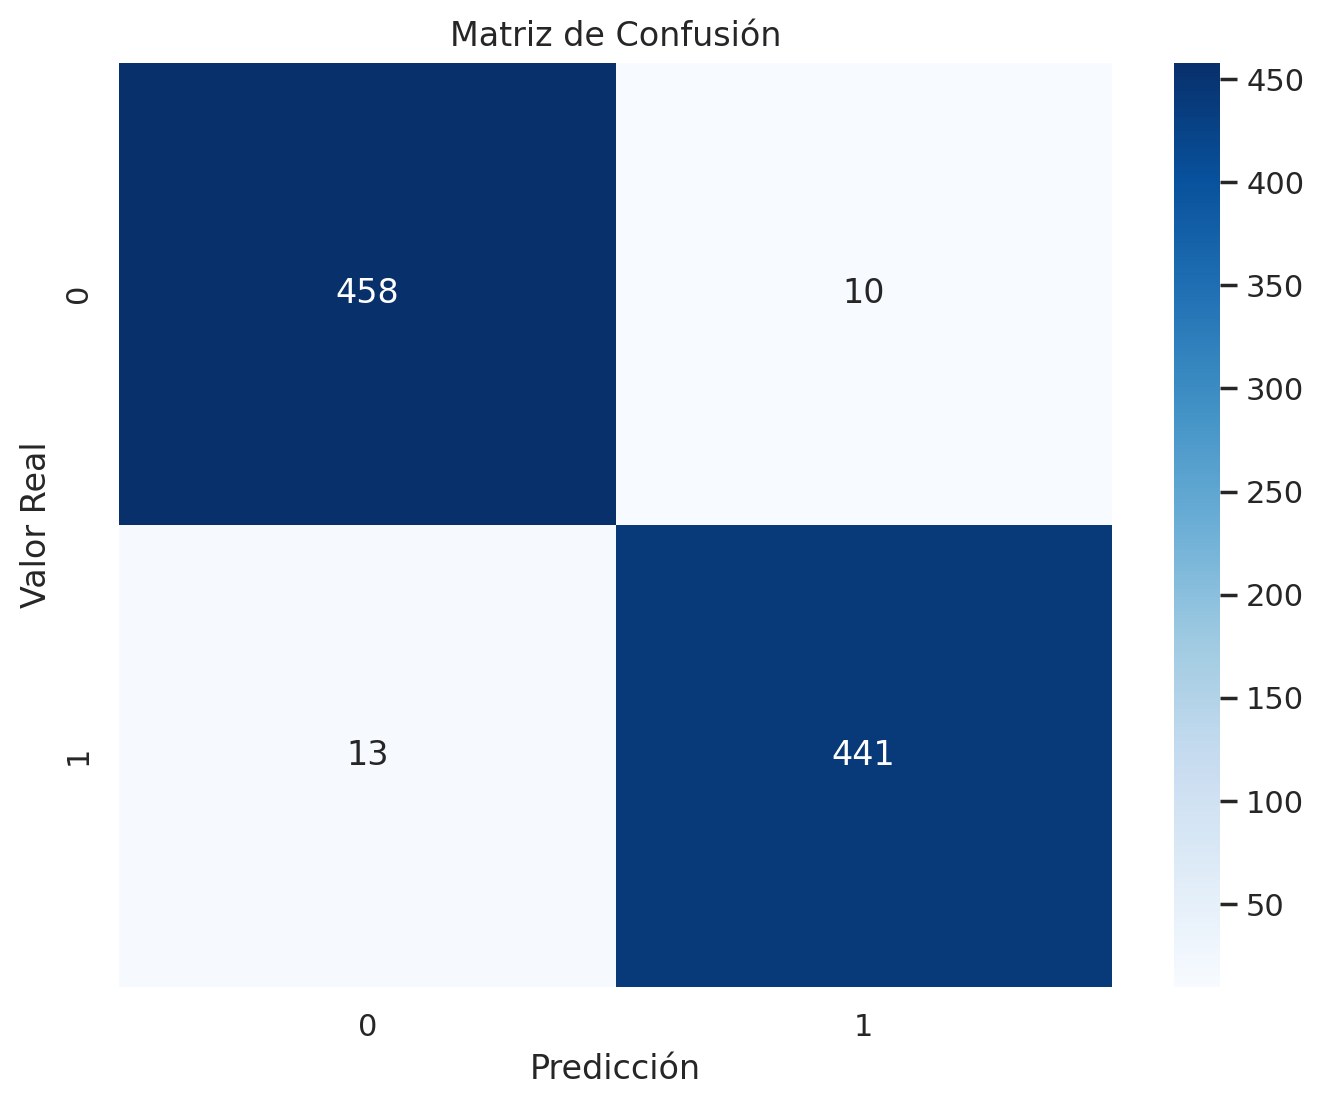

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')

# Mostrar la gráfica
plt.show()

#Análisis (borrador)
la implementación de la bolsa de palabra en conjunto con la técnica de TF-IDF son muy ultil a la hora de caracterizar las palabras en un arreglo vectorial para usarla como datos de entrenamientos a los diferentes modelos.

lo visto en la implementación de estas tecnicas de BoW y TF-IDF es que crea una matriz muy grande de vectores dispersos (si hay 81mil palabaras o vocabulario en el los datos de entrenamiento se crea un vector de 81mil termiminos donde solo 1 sera la representación de esa palabra así con el resto de las 81mil palabra) ocasionado que el proceso de entrenamiento sea muy pesado computacionalmente y a su vez las palabras pierden el consteto al aplicar estas tecnicas de BoW y TF-IDF.

en la parte del costo computacional se hace notar en los otros modelos como SVM, RL y RF que el proceso de entrenamiento es muy demorado al usar un conjunto de entrenamiento de más de 200mil datos. Esto se observa mejor al implementar una red neuronal secuencial donde el proceso es tan elevado que consume toda la RAM y GPU disponible lo que llevo a reducir el tamaño de los datos a 20mil a proximadamente el 10% de la cantidad de los datos en total para poder entrenar el modelo de forma correcta.

aunque se usaron menos datos para la red neuronal fue el modelo que mejor se comporto a la hora de entrenar con estas técnicas ya que obtuvo el mejor resultado de validación con los datos entrenados  y el mejor resultado de evaluación con nuevos datos de prueba.

En conclusión, se puede decir que estas tecnica comple con su cometido de carctetizar los datos en una erreglo vectorial para el entrenamiento de los diferentes modelos de clasificación. Pero conyeva una gran costo computacional a la hora de entrara estos modelos por que el  erreglo vectorial  se compone una gran matriz dispersa.